**Establishing Sequences of Organizational Patterns with bigrams**

Index of the highest probability in a vector of probabilities as output from the Softmax regression model points to first pattern which should be used in pattern sequence. Second-highest probability points to second pattern in this sequence. Third probability points to third pattern in pattern sequence...

This work is a natural continuation of the previous research conducted by Waseeb et al. in their work titled as 'Extracting Relations Between Organizational Patterns Using Association Mining' which you can find here: http://www2.fiit.stuba.sk/~vranic/pub/ExtractingRelations.pdf. 

Dataset we're working with is quite similar to the one published on page 4 in Table 1 entitled as "A matrix sample values for n-gram existence against org. patterns". Difference is that we use TF-IDF frequencies of the words used in text descriptions of these patterns instead of the binary-encoded attributes.

Sample dataset with frequencies of 11 bigrams extracted from textual descriptions of the organizational patterns from http://www.orgpatterns.com/ had been provided in Excel sheets as training, validation and test dataset. Validation and test set consist of another previously unseen 7 organizational patterns.

<u>Model output example</u>:

Training dataset consists of frequencies of the bigrams for 18 organizational patterns. Output from this Artificial Neural Network is a vector for a pattern with frequencies from a validation and test dataset with as many components as there are patterns in a training dataset:

for a $pattern_{i}$ = (x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18),

where $x_{i}$ is output from a softmax regression and it's a likelihood of this pattern given observed frequencies for n-gram.
Biggest value or highest probability from this vector is a classification of the set of the n-gram inverse frequencies of a given organizational pattern.

**Main Idea of our Approach**

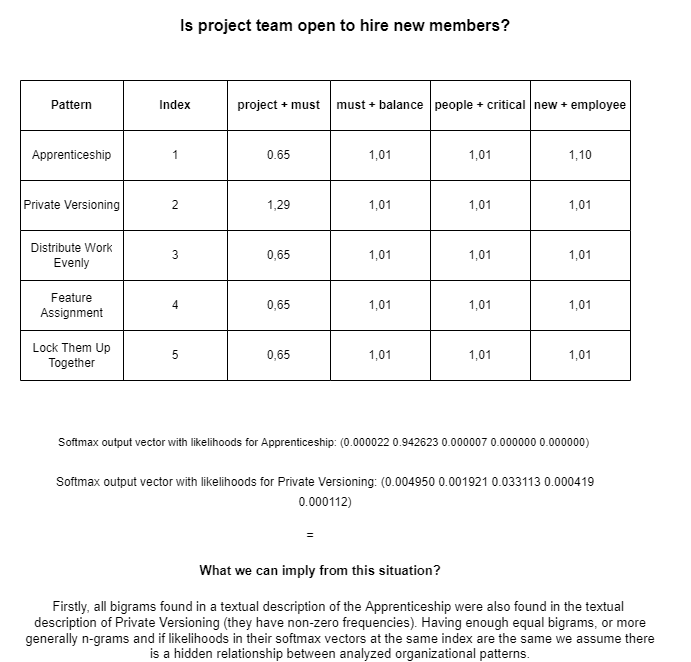

Validation dataset should be used to optimalize hyperparameters (parameters which are not trained during computation of this ANN) and test dataset shall be used only once.

Please note that prediction is correct if it is consistent with an actual class. Accuracy of the model is one of the metrics used to evaluate this behavior.

Theory behind this can be found in a book Dive into Deep Learning: https://d2l.ai/chapter_linear-networks/softmax-regression.html

In [23]:
import tensorflow as tf
# keras is facade for tensorflow so we don't have to deal with low-level API
from tensorflow import keras 
from tensorflow.keras.models import Sequential # composite pattern for building neural network
from tensorflow.keras.layers import Dense # input, hidden and output layer
from tensorflow.keras.losses import categorical_crossentropy # loss function
from keras.utils.np_utils import to_categorical # hot-encoding for softmax regression
from tensorflow.keras.optimizers import Adam # optimalizer for neural network

# library for data preprocessing and model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import numpy as np # to handle data compactly
import pandas as pd
import matplotlib.pyplot as plt # plotting library

import os

# get the current working directory
current_working_directory = os.getcwd()

tf.keras.backend.clear_session()

train_df = pd.read_excel(current_working_directory + '\\bigram-pattern-frequencies\\for-mlp\\bigram-pattern-frequencies-train.xlsx', engine='openpyxl')
val_df = pd.read_excel(current_working_directory + '\\bigram-pattern-frequencies\\for-mlp\\bigram-pattern-frequencies-val.xlsx', engine='openpyxl')
test_df = pd.read_excel(current_working_directory + '\\bigram-pattern-frequencies\\for-mlp\\bigram-pattern-frequencies-test.xlsx', engine='openpyxl')

**Normalization of organizational patterns bigram frequencies**

Why? Because some of the bigrams (independent variables, attributes X) have higher frequencies than the others. This means they are used more in organizational pattern descriptions than those which are used less. We will normalize these attributes so they contribute equally to the model training process. Normalization is often a must-be to in order to get acceptable results from a machine learning or deep learning models.

Because some of the bigrams are used more often than the others they differ in a (statistical) variance. This means they must be normalized because of this fact too. It's not very good to increase learning rate (as one of the hyperparameters of this neural network) when attributes are not normalized before. This could lead to divergency, when we wouldn't be able to find best parameters in our training process.

Good news is we don't have to weigth our labels (indexes representing organizational patterns) since each class (organizational pattern) is represented only once in our working dataset.

In [2]:
number_of_patterns = 19

train_scaler = StandardScaler()
train_without_target = train_df.drop(['PatternIndex'], axis=1)
train_without_pattern_name = train_without_target.drop(['OrganizationalPattern'], axis=1)
train_features = train_scaler.fit(train_without_pattern_name.values)

X_train = pd.DataFrame(train_scaler.transform(train_df.iloc[:, 1:-1].values))
y_train = to_categorical(train_df.iloc[:,-1].values, number_of_patterns) # hot-encoding label (pattern index) for softmax regression

val_scaler = StandardScaler()
val_without_target = val_df.drop(['PatternIndex'], axis=1)
val_without_pattern_name = val_without_target.drop(['OrganizationalPattern'], axis=1)
val_features = val_scaler.fit(val_without_pattern_name.values)

X_val = pd.DataFrame(val_scaler.transform(val_df.iloc[:, 1:-1].values))
y_val = to_categorical(val_df.iloc[:,-1].values, number_of_patterns)

test_scaler = StandardScaler()
test_without_target = test_df.drop(['PatternIndex'], axis=1)
test_without_pattern_name = test_without_target.drop(['OrganizationalPattern'], axis=1)
test_features = test_scaler.fit(test_without_pattern_name.values)

X_test = pd.DataFrame(test_scaler.transform(test_df.iloc[:, 1:-1].values))
y_test = to_categorical(test_df.iloc[:,-1].values, number_of_patterns)  

**Softmax Regression - Classification of the patterns based on the bigram frequencies**

Activation functions are those components in neural networks which are responsible to generate output from the network. Combination of linear functions (layers of the ANN without these functions perform affine transformations only) is still a linear function. That's why we need non-linear activation function. Non-linear activation functions help us to take advantage of the GPU processing capabilities.

We must use non-linear activation functions because if we try to visualize frequencies of the n-grams in 2D space we would not be able to separate these data with linear function / line.

ReLU is one of the standard activation functions used in the neural networks. Softmax is activation function too. Number passed as argument to the constructor of the layer of our Artificial Neural Network is number of perceptrons on this layer. Dropout layer is used as regularization technique to eliminate overfitting of the model on training dataset.

First dense layer is our input layer, or layer to consume our dataset. It has 11 neurons, because we have 11 bigrams in our training dataset. Last layer is output layer of this neural network. All layers between are hidden layers of this network. All layers are fully connected layers of this Multi-layer perceptron.

What we're doing here? Well, we go through these steps for 100 epochs:

 1. we pass here our dataset
 2. we declare ANN as MLP. See https://d2l.ai/chapter_multilayer-perceptrons/index.html
 3. we declare optimizer which we want to use. It's Adam, best in class: https://arxiv.org/pdf/1412.6980.pdf
 4. we work with-minibatches. 
 5. we perform forward pass through this network. This means we generate predictions.
 6. we compute loss of the predictions
 7. we propagate back this loss through all the layers of this ANN. In fact we propagate gradients.
 8. then we use these parameters for another forward pass of this MLP.

At the end we use one of the standards visualization techniques for model evaluation.

In [13]:
NUMBER_OF_TF_IDF_FEATURES = 11

# default weight initializer is glorot_uniform
ann = tf.keras.Sequential([
  tf.keras.layers.InputLayer(NUMBER_OF_TF_IDF_FEATURES),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),  # number of neurons in layer is usually exponent of 2w
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.35),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(19, activation=tf.nn.softmax)
])

ann.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=["accuracy"])

ann.summary() # architecture of this artificial neural network

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               6144      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 512)              

In [14]:
BATCH_SIZE = 19
EPOCHS = 100
SHUFFLE = True

history = ann.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_val, y_val), shuffle=SHUFFLE)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 4.1545 - accuracy: 0.0000e+00 - val_loss: 2.9284 - val_accuracy: 0.1111
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 2.7688 - accuracy: 0.1111 - val_loss: 2.9166 - val_accuracy: 0.1111
Epoch 3/100
1/1 [==============================] - 0s 30ms/step - loss: 2.7128 - accuracy: 0.1667 - val_loss: 2.9077 - val_accuracy: 0.1111
Epoch 4/100
1/1 [==============================] - 0s 30ms/step - loss: 2.5760 - accuracy: 0.2778 - val_loss: 2.8959 - val_accuracy: 0.1111
Epoch 5/100
1/1 [==============================] - 0s 30ms/step - loss: 2.3768 - accuracy: 0.2778 - val_loss: 2.8841 - val_accuracy: 0.1111
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 2.5926 - accuracy: 0.1667 - val_loss: 2.8739 - val_accuracy: 0.1111
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 2.1708 - accuracy: 0.3333 - val_loss: 2.8637 - val_accuracy: 0.1111
Epoch 8/100
1/1 [=

1/1 [==============================] - 0s 32ms/step - loss: 2.1113 - accuracy: 0.2778 - val_loss: 2.7808 - val_accuracy: 0.1111
Epoch 60/100
1/1 [==============================] - 0s 31ms/step - loss: 2.0033 - accuracy: 0.2222 - val_loss: 2.7811 - val_accuracy: 0.1111
Epoch 61/100
1/1 [==============================] - 0s 31ms/step - loss: 1.9033 - accuracy: 0.2778 - val_loss: 2.7815 - val_accuracy: 0.1111
Epoch 62/100
1/1 [==============================] - 0s 30ms/step - loss: 1.9467 - accuracy: 0.2778 - val_loss: 2.7823 - val_accuracy: 0.1111
Epoch 63/100
1/1 [==============================] - 0s 31ms/step - loss: 1.9644 - accuracy: 0.2222 - val_loss: 2.7856 - val_accuracy: 0.1111
Epoch 64/100
1/1 [==============================] - 0s 31ms/step - loss: 2.1216 - accuracy: 0.2222 - val_loss: 2.7886 - val_accuracy: 0.1111
Epoch 65/100
1/1 [==============================] - 0s 31ms/step - loss: 1.8043 - accuracy: 0.2778 - val_loss: 2.7913 - val_accuracy: 0.1111
Epoch 66/100
1/1 [========

We still have a low accuracy (bias) mostly because we still deal with a very small dataset. Loss here is a value of the cost function (losses for all predictions). Val_loss is a model variance.

Because loss is lower than a validation loss (though still not significantly) our probability prediction model is said to be <u>overfitting</u>. This is why we have employed one of the regularization techniques for neural networks - we've added Dropout layer. Documentation for this approach can be found in the work of Srivastava et al. Dropout - A Simple Way to Prevent Neural Networks from Overfitting which you can find here https://jmlr.org/papers/v15/srivastava14a.html

Below are the parameters or knowledge about the dataset of TF-IDF frequencies of organizational patterns which our artificial neural network has learned

In [15]:
ann.get_weights()

[array([[0.023968, -0.066423, 0.063804, ..., 0.061571, -0.100212,
         -0.047257],
        [0.048469, 0.042543, 0.034170, ..., 0.050181, -0.006951, 0.010830],
        [0.119092, -0.012446, 0.010959, ..., -0.023922, 0.089265,
         0.052988],
        ...,
        [-0.014697, 0.010563, -0.031430, ..., 0.015822, -0.100676,
         0.078304],
        [0.030887, -0.058223, 0.099167, ..., 0.023251, 0.045647, 0.089224],
        [0.020850, -0.104754, -0.001916, ..., 0.006934, 0.061618,
         0.000524]], dtype=float32),
 array([0.017511, 0.004259, 0.001449, -0.003331, 0.006825, -0.001177,
        0.006890, -0.010423, -0.001907, -0.018166, -0.017186, 0.006900,
        -0.004281, -0.000127, -0.000831, 0.001824, 0.008929, -0.001804,
        -0.006326, 0.005176, -0.009851, 0.001594, 0.006067, -0.000438,
        0.009715, 0.005133, 0.001689, 0.000837, -0.003173, 0.008552,
        0.003500, 0.003976, -0.000246, -0.012675, -0.008261, 0.001431,
        0.006271, 0.000671, 0.008492, 0.002485,

**ANN Training Visualization**

Model is overfitting on training data which means we should alter it so it better generalizes information found in patterns dataset (but we're not doing that now because we have only 1.6 % accuracy).

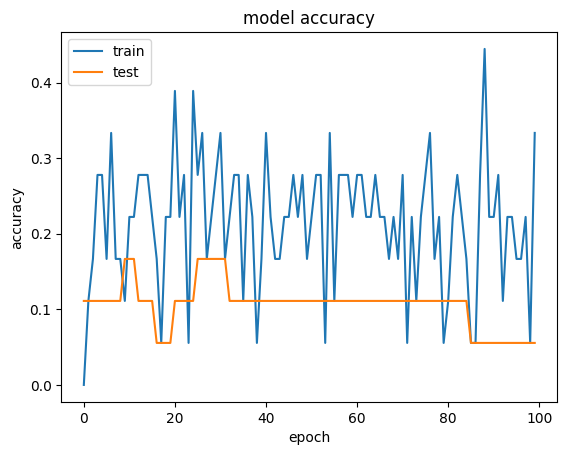

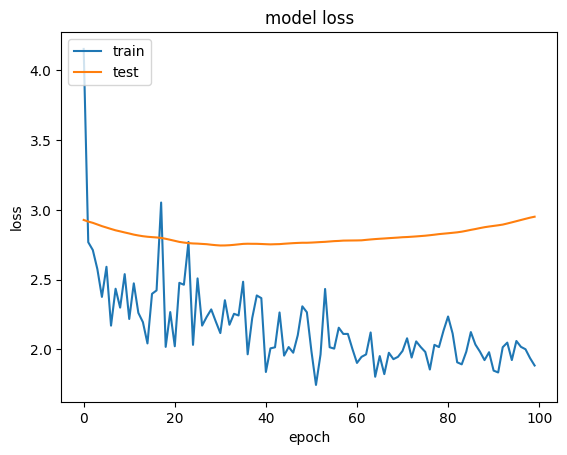

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Architecture of this Artificial Neural Network**

In [17]:
ann.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               6144      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 512)              

**Evaluation of the Multilayer perceptron**

Now we have to evaluate our classification model. Non-overfitting softmax regression model for us is a model with a roughly same accuracy exhibited on a training, validation and test dataset. Visualization through the confusion matrix will help us evaluate model performance on these three types of the data sets.

We're going to check our classification accuracy on the test dataset. For evaluation we use a confusion matrix. Confusion matrix consists from the ones and zeros because in our case each organizational pattern in our dataset is represented only once. This could be changed by processing other pattern descriptions from other types of sources but always for the same pattern set. Ones are visible at those places where model classified organizational pattern based on its inverse bigram frequencies.

**Model Evaluation on validation dataset**

Although model is a deep neural network and should be strong enough, it's incapable to classify most of the organizational patterns according a pair of terms which have been used to document these organizational patterns. Model has successfully identified Architect Controls Product organizational pattern.

It was found that sentences created by concatenating bigrams: 
- "project must" + "must balance" + "domain expertise" = sentence "project must balance domain expertise"
- "need enough" + "enough people" = "need enough people"

most probably describe problem solved by the Architect Controls Product from the Coplien and Harrison. 

**Expected pattern sequence from the patterns in the validations set**

It is expected above sequence describes the problem which can be solved by this pattern sequence.

Architect Controls Product (p=0.228964) -> Few Roles (p = 0.126118 ) -> Code Ownership (p=0.119162)

1/1 [==============================] - 0s 17ms/step
probabilities in softmax vectors
each value in this vector is a probability that a given row / textual description is a pattern from dataset
[[0.009272 0.214135 0.090662 0.002570 0.009516 0.018163 0.026007 0.006750
  0.417499 0.110029 0.028039 0.008394 0.003366 0.004437 0.010754 0.017720
  0.011446 0.006422 0.004818]
 [0.005706 0.024242 0.119162 0.010284 0.042021 0.027298 0.020215 0.021080
  0.442579 0.008364 0.069301 0.026238 0.027592 0.026104 0.017509 0.060816
  0.015841 0.024603 0.011043]
 [0.001910 0.004894 0.004920 0.078004 0.080100 0.003396 0.063303 0.060118
  0.018499 0.003427 0.004958 0.053885 0.063963 0.126118 0.051712 0.228964
  0.051396 0.038550 0.061883]
 [0.005706 0.024242 0.119162 0.010284 0.042021 0.027298 0.020215 0.021080
  0.442579 0.008364 0.069301 0.026238 0.027592 0.026104 0.017509 0.060816
  0.015841 0.024603 0.011043]
 [0.005706 0.024242 0.119162 0.010284 0.042021 0.027298 0.020215 0.021080
  0.442579 0.008364 0

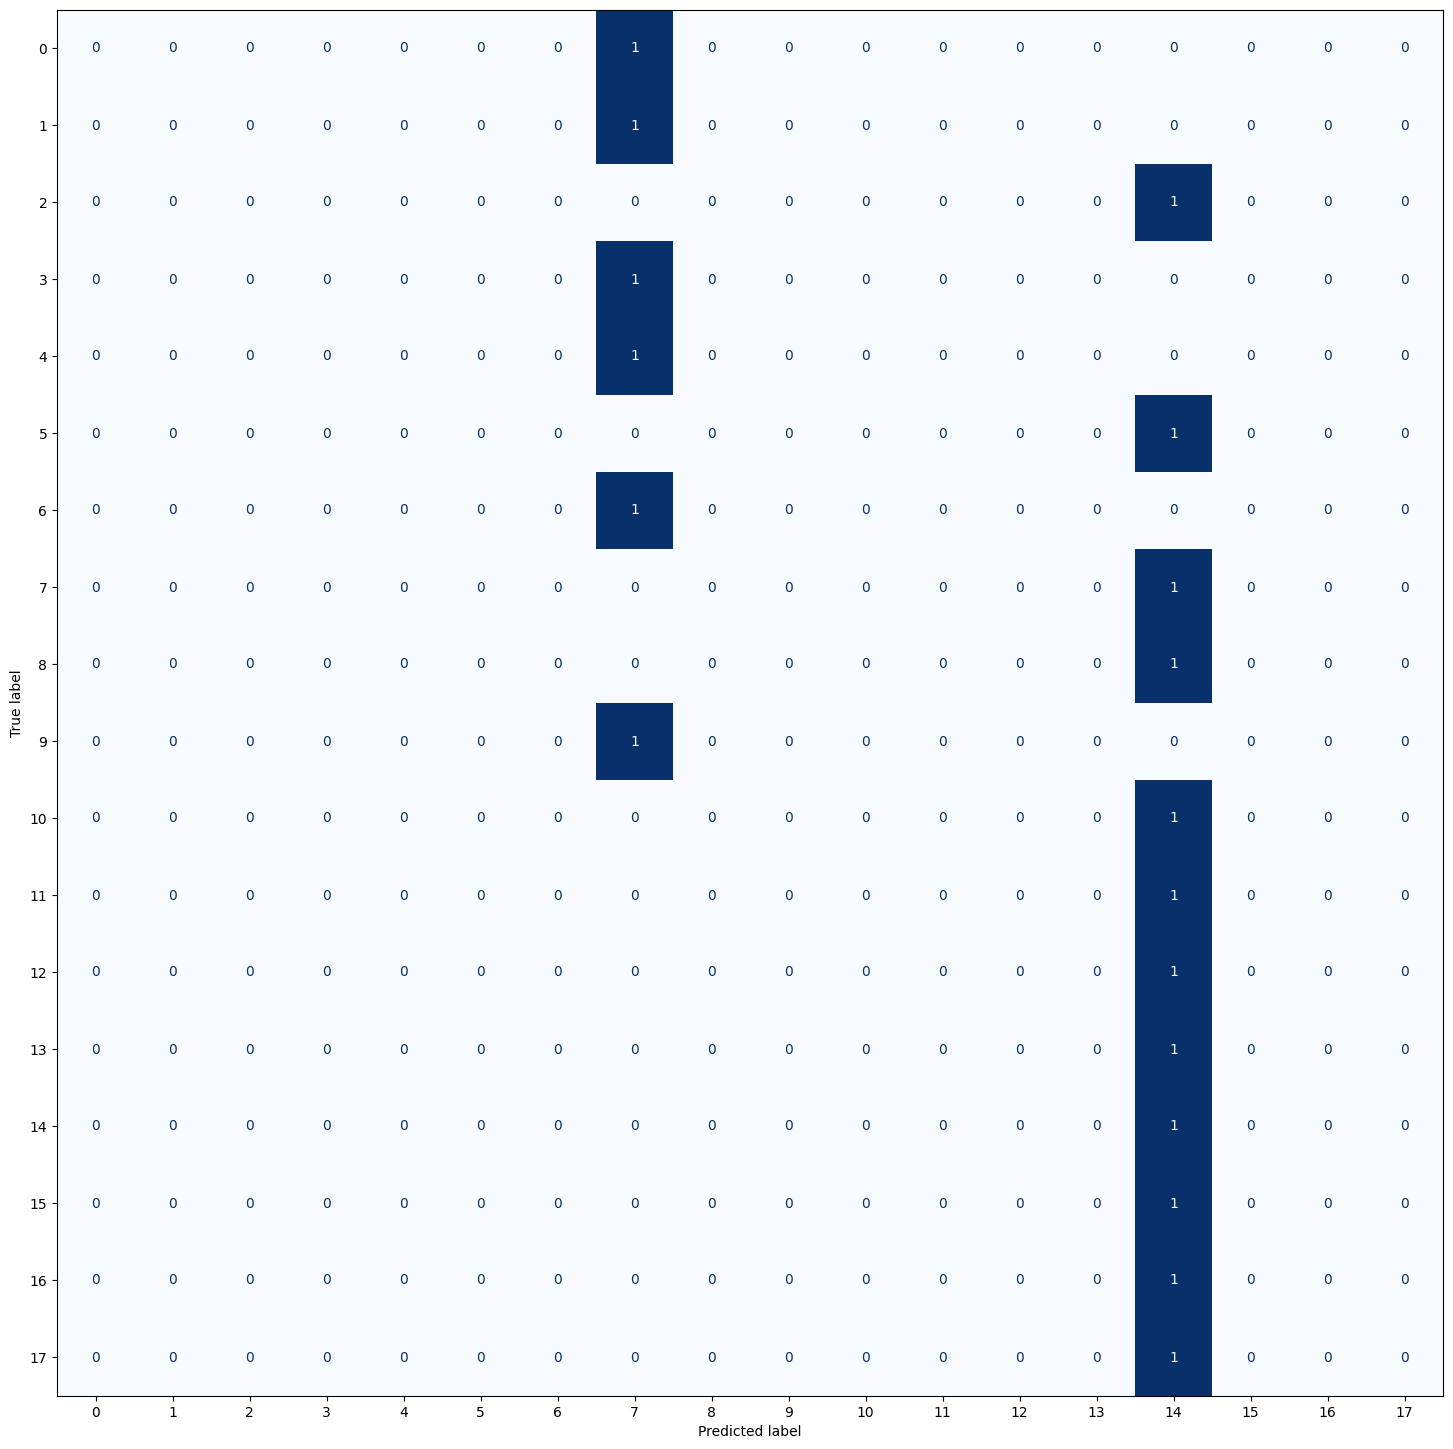

In [20]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(18))
    cm.plot(values_format='d', cmap='Blues', ax=ax, colorbar=False)
    
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

softmax_vectors = ann.predict(X_val)
print('probabilities in softmax vectors')
print('each value in this vector is a probability that a given row / textual description is a pattern from dataset')
print(softmax_vectors)
indexes_of_predicted_patterns = np.argmax(softmax_vectors, axis=1)
pattern_names_from_one_hot_encodings = np.argmax(y_val, axis=1)
plot_confusion_matrix(pattern_names_from_one_hot_encodings, indexes_of_predicted_patterns)

**Model Evaluation on test dataset**

Although model is a deep neural network and should be strong enough, it's incapable to classify most of the organizational patterns according a pair of terms which have been used to document these organizational patterns. Model has successfully identified Apprenticeship and Architect Controls Product organizational patterns.

It was found that sentences created by concatenating bigrams: 
- "project must" + "must balance" + "domain expertise" = sentence "project must balance domain expertise"
- "need enough" + "enough people" = "need enough people"

most probably describe problem solved by the Architect Controls Product from the Coplien and Harrison. 

**Expected pattern sequence from the patterns in the test set**

It is expected above sequence describes the problem which can be solved by this pattern sequence.

Generics and Specifics (p=0.562330) -> Distribute Work Evenly (p=0.356492) -> Architect Controls Product (p=0.238690)

1/1 [==============================] - 0s 16ms/step
probabilities in softmax vectors
each value in this vector is a probability that a given row / textual description is a pattern from dataset
[[0.009295 0.356492 0.106389 0.001371 0.003950 0.019934 0.013203 0.002439
  0.275022 0.134661 0.051722 0.004112 0.001068 0.001698 0.002777 0.006255
  0.004085 0.002848 0.002678]
 [0.005265 0.021034 0.115033 0.006602 0.028298 0.026090 0.012997 0.013428
  0.562330 0.006677 0.064009 0.018345 0.017401 0.018184 0.012099 0.039018
  0.009865 0.016968 0.006357]
 [0.001885 0.005802 0.005612 0.077653 0.087869 0.003803 0.061569 0.055379
  0.024184 0.003799 0.005633 0.051278 0.059160 0.121558 0.053453 0.238690
  0.049892 0.037645 0.055136]
 [0.001885 0.005802 0.005612 0.077653 0.087869 0.003803 0.061569 0.055379
  0.024184 0.003799 0.005633 0.051278 0.059160 0.121558 0.053453 0.238690
  0.049892 0.037645 0.055136]
 [0.001885 0.005802 0.005612 0.077653 0.087869 0.003803 0.061569 0.055379
  0.024184 0.003799 0

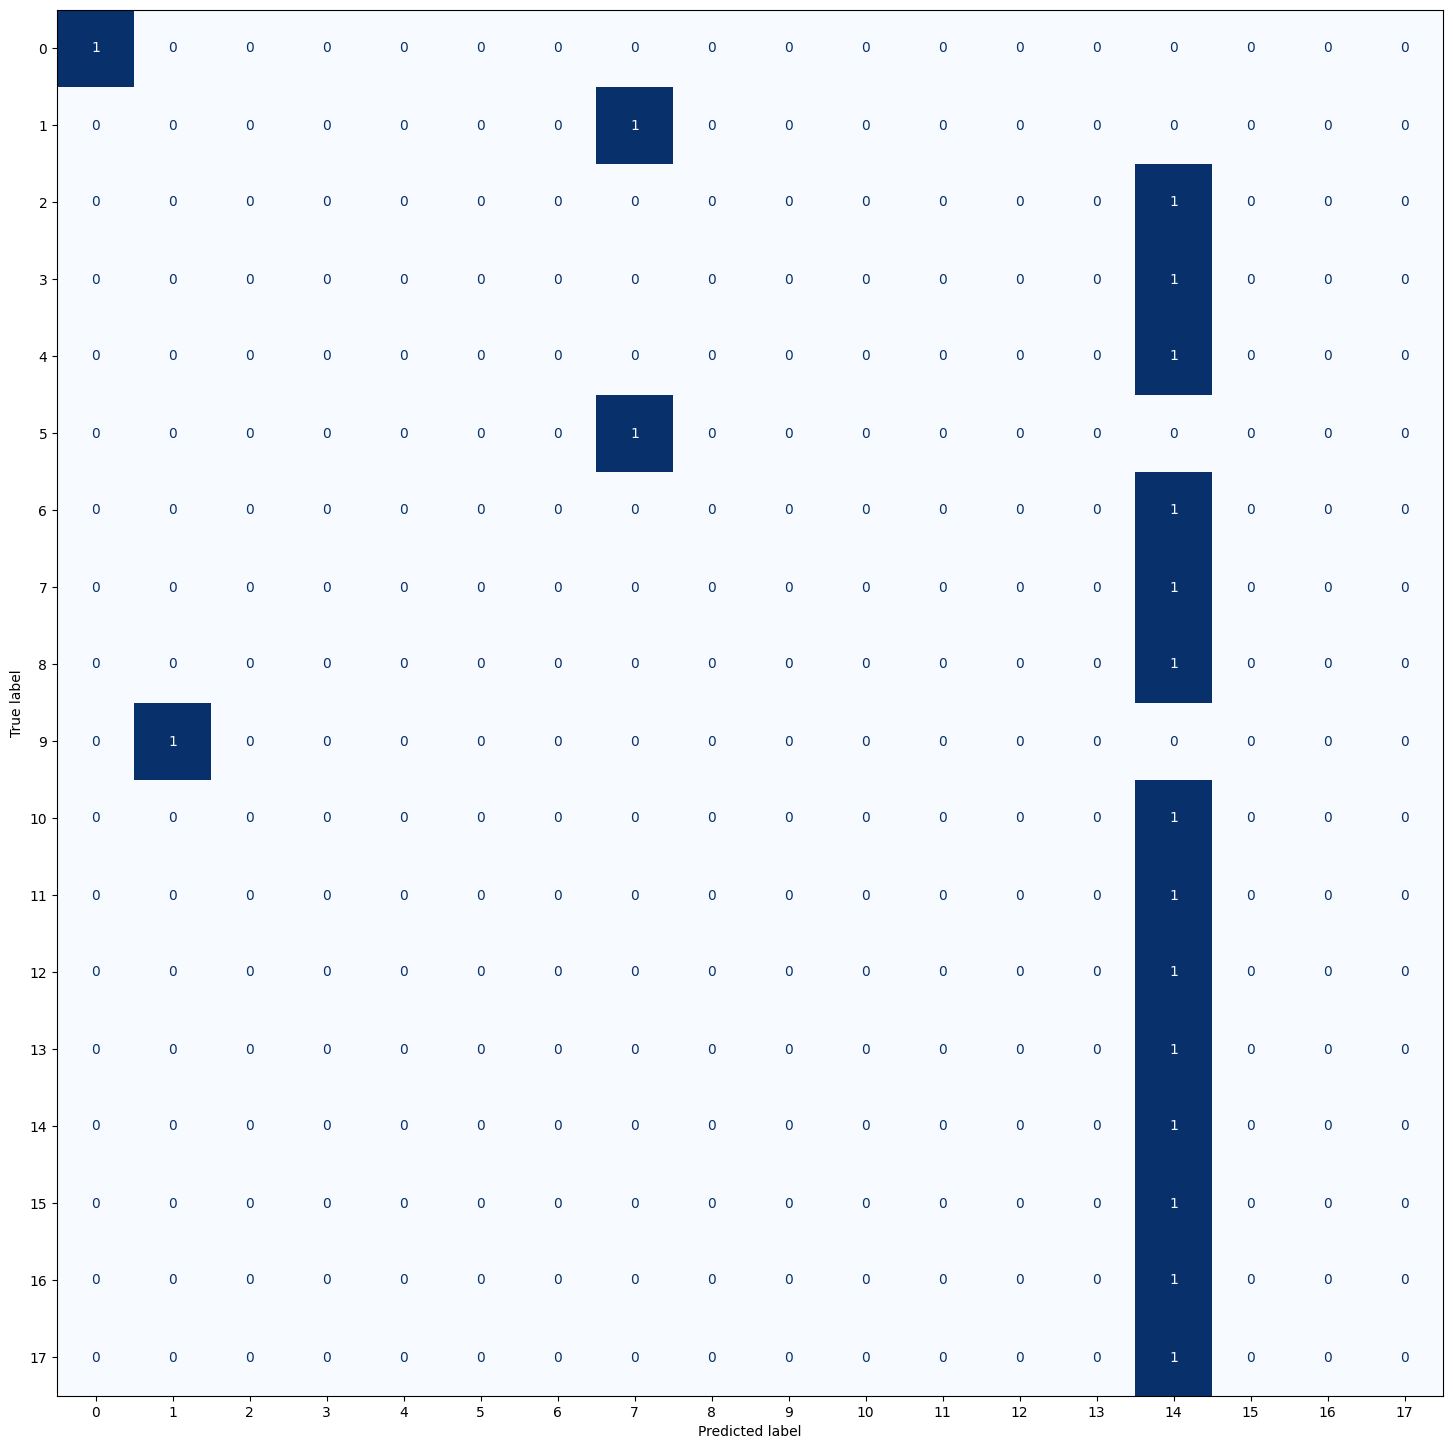

In [22]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(18))
    cm.plot(values_format='d', cmap='Blues', ax=ax, colorbar=False)
    
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

softmax_vectors = ann.predict(X_test)
print('probabilities in softmax vectors')
print('each value in this vector is a probability that a given row / textual description is a pattern from dataset')
print(softmax_vectors)
indexes_of_predicted_patterns = np.argmax(softmax_vectors, axis=1)
pattern_names_from_one_hot_encodings = np.argmax(y_test, axis=1)
plot_confusion_matrix(pattern_names_from_one_hot_encodings, indexes_of_predicted_patterns)

**Conclusion**

This model should be provided extensive dataset, with more than pairs of the terms (trigrams), more attributes and more organizational patterns from numerous sources.